In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from omegaconf import OmegaConf
import pandas as pd

In [3]:
from dinov2.models.vision_transformer import vit_large
from dinov2.models import build_model_from_cfg
from dinov2.utils.utils import load_pretrained_weights

/home/guevel/OT4D/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/guevel/OT4D/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/guevel/OT4D/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [4]:
config_path = "/home/guevel/OT4D/cell_similarity/vit_large_multidataset/config.yaml"
cfg = OmegaConf.load(config_path)

model, _ = build_model_from_cfg(cfg, only_teacher=True)

path_model = "/home/guevel/OT4D/cell_similarity/vit_large_multidataset/eval/training_124999/teacher_checkpoint.pth"
load_pretrained_weights(model, path_model, "teacher")

In [4]:
model.eval()
model.cuda()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): BlockChunk(
      (0-5): 6 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFNFused(
          (w12): Linear(in_features=1024, out_features=5472, bias=True)
          (w3): Linear(in_features=2736, out_features=1024, bias=True)
        )
        (ls2): LayerScale()
        (drop_path2): Identity()
      )
    )
    (1): BlockC

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),    
    transforms.ToTensor()
])

In [6]:
from torchvision.datasets import ImageFolder
data_path = "/home/manon/classification/data/Single_cells/barcelona"

dataset = ImageFolder(data_path, transform=transform)

In [7]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=64)

In [8]:
from tqdm import tqdm

embeddings = []
labels = []
for batch, lab in tqdm(dataloader):
    batch, lab = batch.cuda(), lab.cuda()
    with torch.no_grad():
        outputs = model(batch)
        embeddings.append(outputs)
        labels.append(lab)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [03:18<00:00,  1.35it/s]


In [12]:
emb = torch.cat(embeddings).cpu()
labs = torch.cat(labels).cpu()
emb.shape

torch.Size([17101, 1024])

In [56]:
torch.save(emb, "cache/barcelona_embs_vitl.pt")
torch.save(labs, "cache/barcelona_labels.pt")

In [10]:
import umap

uemb = umap.UMAP().fit_transform(emb)

In [32]:
paths = [pair[0] for pair in dataset.imgs]
data = []
translate = {v: k for k, v in dataset.class_to_idx.items()}

for e, path, c in zip(uemb, paths, labs):
    data.append([e[0], e[1], translate[c.tolist()], path])

In [33]:
df_emb = pd.DataFrame(data, columns=["x", "y", "class", "name"])
df_emb.head()

,x,y,class,name
0,10.387290,6.625940,band_neutrophil,/home/manon/classification/data/Single_cells/b...
1,11.605177,6.835135,band_neutrophil,/home/manon/classification/data/Single_cells/b...
2,10.696140,7.690961,band_neutrophil,/home/manon/classification/data/Single_cells/b...
3,11.293275,8.093492,band_neutrophil,/home/manon/classification/data/Single_cells/b...
4,11.059027,4.271073,band_neutrophil,/home/manon/classification/data/Single_cells/b...


<Figure size 1200x1600 with 0 Axes>

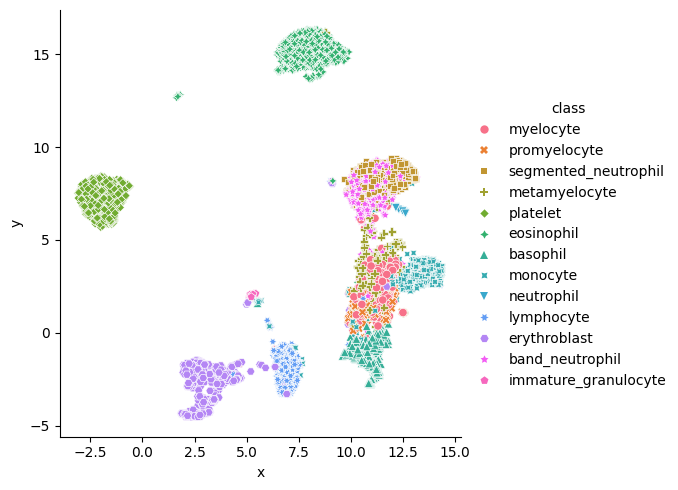

In [57]:
import seaborn as sns

df_plot = df_emb.sample(frac=0.5)

plt.figure(figsize=(12,16))
sns.relplot(
    data=df_plot,
    x="x", y="y", hue="class", style="class"
)
plt.show()